In [2]:
import pandas as pd

In [3]:
regression_df = pd.read_csv('regression_df.csv')

LINEAR DML approach

In [ ]:
import pandas as pd
import numpy as np
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('regression_df.csv')

# Preprocess data
filtered_data = data[(data['intheset'] == 1) & (data['mydate'] <= 617) & (data['firm_scope'] < 50)]
# Define variables
y = filtered_data['ir']
T = filtered_data['TREATED'].astype(int)  # Ensure binary nature with int
X = filtered_data[['firm_scope', 'aum_x', 'firm_age', 'age', 'aum_firm']].fillna(0)  # Fill NA for simplicity in this example
W = filtered_data[['year_dum_1994', 'year_dum_1995', 'year_dum_1996', 'year_dum_1997', 
                   'year_dum_1998', 'year_dum_1999', 'year_dum_2000', 'year_dum_2001', 
                   'year_dum_2002', 'year_dum_2003', 'year_dum_2004', 'year_dum_2005', 
                   'year_dum_2006', 'year_dum_2007', 'year_dum_2009', 'year_dum_2010']].fillna(0)

# Align y and T to X's index after filling NAs
y = y[X.index]
T = T[X.index]

# Split data
X_train, X_test, T_train, T_test, y_train, y_test, W_train, W_test = train_test_split(X, T, y, W, test_size=0.3, random_state=42)

# Define DML model
est = LinearDML(model_y=RandomForestRegressor(n_estimators=100, random_state=42),
                model_t=RandomForestClassifier(n_estimators=100, random_state=42),
                linear_first_stages=False, discrete_treatment=True)  # Specify discrete treatment

# Fit model without int1c
est.fit(y_train, T_train, X=X_train, W=W_train)

# Estimate treatment effect
treatment_effect = est.effect(X_test)
print("Treatment effect without int1c:", np.mean(treatment_effect))

# If int1c is available and to be included
if 'int1c' in filtered_data.columns:
    X['int1c'] = filtered_data['int1c']
    
    # Re-split data with int1c
    X_train, X_test, T_train, T_test, y_train, y_test, W_train, W_test = train_test_split(X, T, y, W, test_size=0.3, random_state=42)
    
    # Fit model with int1c
    est.fit(y_train, T_train, X=X_train, W=W_train)
    
    # Estimate treatment effect with int1c
    treatment_effect_int1c = est.effect(X_test)
    print("Treatment effect with int1c:", np.mean(treatment_effect_int1c))

CAUSALFORESTDML approach

               CATE   Lower Bound   Upper Bound
count  28294.000000  28294.000000  28294.000000
mean      -0.040565     -0.465830      0.384701
std        0.545100      1.197047      0.637455
min      -12.862639    -37.546113     -0.496905
25%       -0.438546     -0.767902     -0.085035
50%        0.060347     -0.259165      0.386342
75%        0.323140      0.043853      0.678986
max        1.858914      0.816662     13.473383


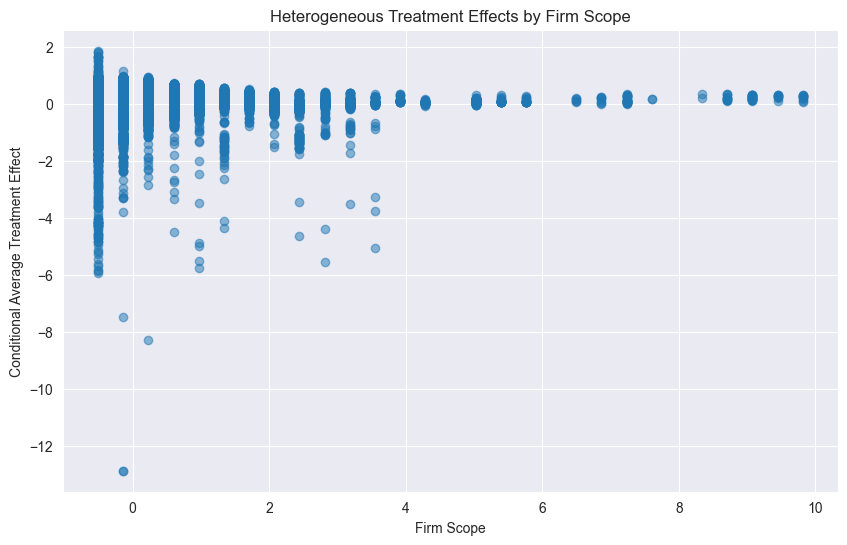

      feature  importance
4    aum_firm    0.329849
1       aum_x    0.319572
0  firm_scope    0.158102
2    firm_age    0.115557
3         age    0.076919


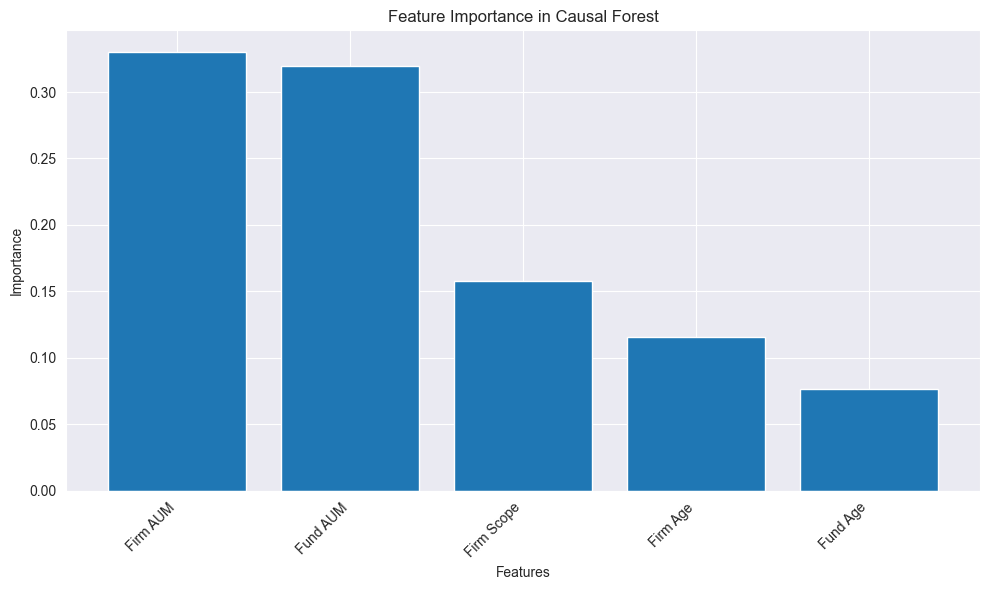

In [5]:
import pandas as pd
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('regression_df.csv')

# Preprocess data
filtered_data = data[(data['intheset'] == 1) & (data['mydate'] <= 617) & (data['firm_scope'] < 50)]

# Define variables
y = filtered_data['ir']
T = filtered_data['TREATED'].astype(int)  # Ensure binary nature with int
X = filtered_data[['firm_scope', 'aum_x', 'firm_age', 'age', 'aum_firm']].fillna(0)  # Fill NA for simplicity
W = filtered_data[['year_dum_1994', 'year_dum_1995', 'year_dum_1996', 'year_dum_1997', 
                   'year_dum_1998', 'year_dum_1999', 'year_dum_2000', 'year_dum_2001', 
                   'year_dum_2002', 'year_dum_2003', 'year_dum_2004', 'year_dum_2005', 
                   'year_dum_2006', 'year_dum_2007', 'year_dum_2009', 'year_dum_2010']].fillna(0)
# X['Firm Scope'] = X['firm_scope']
# X = X['firm_scope'].drop()
# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, T_train, T_test, y_train, y_test, W_train, W_test = train_test_split(X_scaled, T, y, W, test_size=0.3, random_state=42)

# Define models for outcome and treatment
model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Instantiate and fit the Causal Forest model
cf = CausalForestDML(model_y=model_y, model_t=model_t, n_estimators=1000, max_depth=5, random_state=42)
cf.fit(y_train, T_train, X=X_train, W=W_train)

# Estimate treatment effects
te_pred = cf.effect(X_test)

# Inference for confidence intervals
lb, ub = cf.effect_interval(X_test)

# Analyze results
results = pd.DataFrame({
    'CATE': te_pred,
    'Lower Bound': lb,
    'Upper Bound': ub
})

print(results.describe())

# Visualize heterogeneous treatment effects by firm scope
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X_test['firm_scope'], te_pred, alpha=0.5)
plt.xlabel('Firm Scope')
plt.ylabel('Conditional Average Treatment Effect')
plt.title('Heterogeneous Treatment Effects by Firm Scope')
plt.show()

# Feature importance
feature_importance = cf.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)
feature_name_mapping = {
    'firm_scope': 'Firm Scope',
    'aum_x': 'Fund AUM',
    'firm_age': 'Firm Age',
    'age': 'Fund Age',
    'aum_firm': 'Firm AUM'
}

# Replace the feature names in the importance_df with the new names
importance_df['feature'] = importance_df['feature'].map(feature_name_mapping)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Causal Forest')
plt.tight_layout()
plt.show()

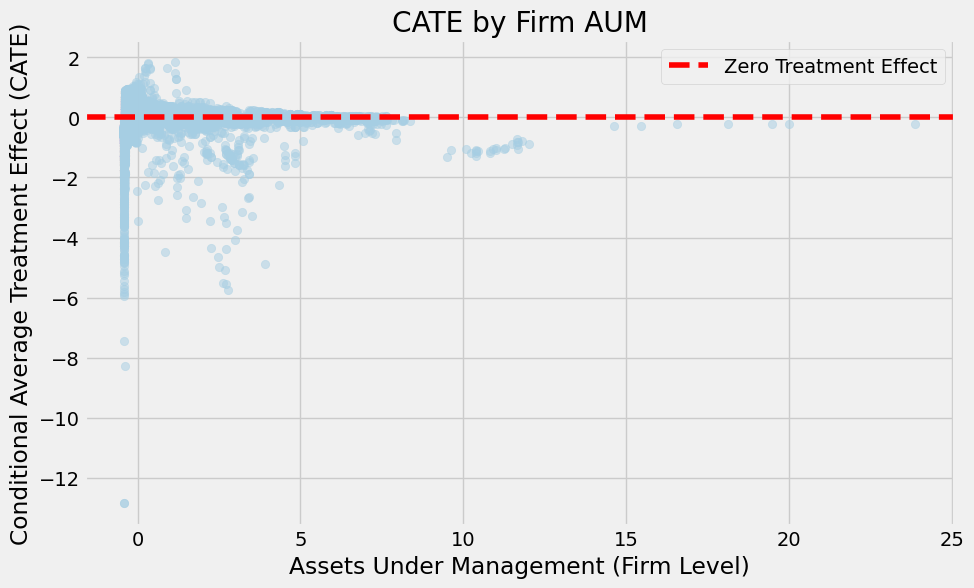

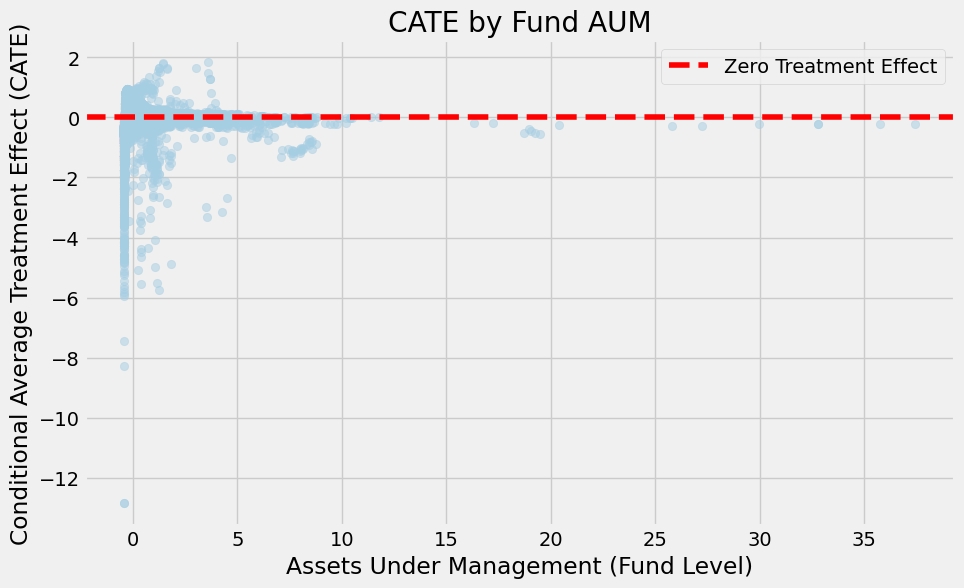

In [28]:
# Scatter plot of CATE vs. aum_firm
plt.figure(figsize=(10, 6))
plt.scatter(X_test['aum_firm'], te_pred, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Treatment Effect')
plt.xlabel('Assets Under Management (Firm Level)')
plt.ylabel('Conditional Average Treatment Effect (CATE)')
plt.title('CATE by Firm AUM')
plt.legend()
plt.show()

# Scatter plot of CATE vs. aum_x
plt.figure(figsize=(10, 6))
plt.scatter(X_test['aum_x'], te_pred, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Treatment Effect')
plt.xlabel('Assets Under Management (Fund Level)')
plt.ylabel('Conditional Average Treatment Effect (CATE)')
plt.title('CATE by Fund AUM')
plt.legend()
plt.show()

From the scatter plots:

	•	CATE by Firm AUM and Fund AUM: The plots show a clustering of data points below the zero treatment effect line across most AUM values, indicating predominantly negative treatment effects. However, as AUM increases, the CATE values are less negative, especially at higher AUM values, which implies that firms and funds with higher AUM might be mitigating the negative effects of the treatment more effectively than those with lower AUM.


In [31]:
import statsmodels.api as sm

# Add constant to the model
X_with_const_firm = sm.add_constant(X_test['aum_firm'])
X_with_const_fund = sm.add_constant(X_test['aum_x'])

# Regression model for aum_firm
model_firm = sm.OLS(te_pred, X_with_const_firm).fit()
print("Regression results for Firm AUM:")
print(model_firm.summary())

# Regression model for aum_x
model_fund = sm.OLS(te_pred, X_with_const_fund).fit()
print("Regression results for Fund AUM:")
print(model_fund.summary())

Regression results for Firm AUM:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     24.22
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           8.65e-07
Time:                        15:07:50   Log-Likelihood:                -22966.
No. Observations:               28294   AIC:                         4.594e+04
Df Residuals:                   28292   BIC:                         4.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.04

SIMILARLY TO THE REGRESSION we will be simplifying the variables for increased significance:

Regression Analysis Results

	•	Firm AUM: The regression coefficient for aum_firm is positive (0.0158), which, despite the overall negative treatment effect, suggests that increases in AUM at the firm level are associated with a less negative (or more positive) treatment effect. This indicates that higher firm AUM slightly mitigates the negative impacts of the treatment.
	•	Fund AUM: Similarly, the coefficient for aum_x is also positive (0.0398) and statistically significant. This larger coefficient compared to firm AUM suggests a stronger mitigating effect on the negative treatment outcomes as the AUM at the fund level increases.


ADDITIONAL ANALYSIS FOR RESULTS SECTION

In [32]:
import statsmodels.api as sm

# Prepare the data
data['interaction_firm_aum'] = data['TREATED'] * data['aum_firm']
data['interaction_fund_aum'] = data['TREATED'] * data['aum_x']
data['interaction_firm_scope'] = data['TREATED'] * data['firm_scope']

# Define the model with interaction terms
X = data[['TREATED', 'aum_firm', 'aum_x', 'firm_scope', 'interaction_firm_aum', 'interaction_fund_aum', 'interaction_firm_scope']]
X = sm.add_constant(X)
Y = data['ir']

# Run the regression
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ir   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.07
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           8.11e-20
Time:                        15:21:56   Log-Likelihood:            -1.4854e+05
No. Observations:               94311   AIC:                         2.971e+05
Df Residuals:                   94303   BIC:                         2.972e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [45]:
# Create a DataFrame from te_pred if it's not already a DataFrame
te_pred_df = pd.DataFrame(te_pred, columns=['CATE'])

# Assuming `data` and `te_pred_df` are aligned and correctly ordered
data['CATE'] = te_pred_df['CATE']

# Now, you can proceed with your analyses such as regression or grouping
# Here's an example of how you might calculate descriptive statistics for groups
grouped_stats = data.groupby('TREATED').agg({'CATE': ['mean', 'std', 'min', 'max']})
print(grouped_stats)

             CATE                               
             mean       std        min       max
TREATED                                         
0       -0.040507  0.544956 -12.862639  1.858914
1       -0.043234  0.552164  -4.830084  1.643354


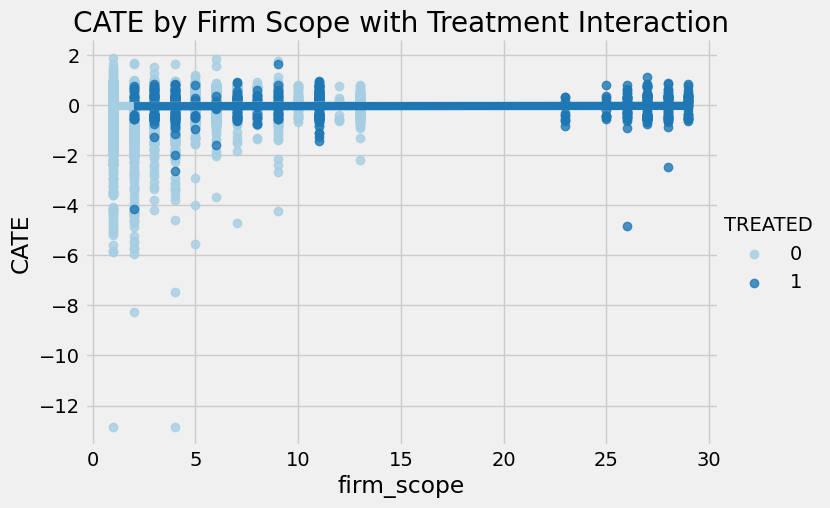

In [46]:
# Ensure the indices match for data and predictions
import seaborn as sns

# Visualization for interaction effects
sns.lmplot(x='firm_scope', y='CATE', hue='TREATED', data=data, aspect=1.5)
plt.title('CATE by Firm Scope with Treatment Interaction')
plt.show()

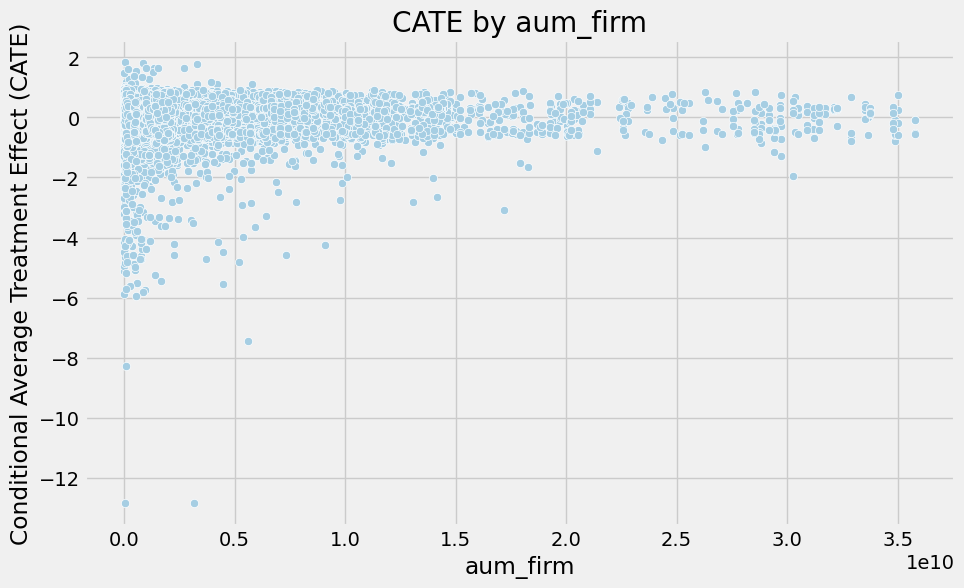

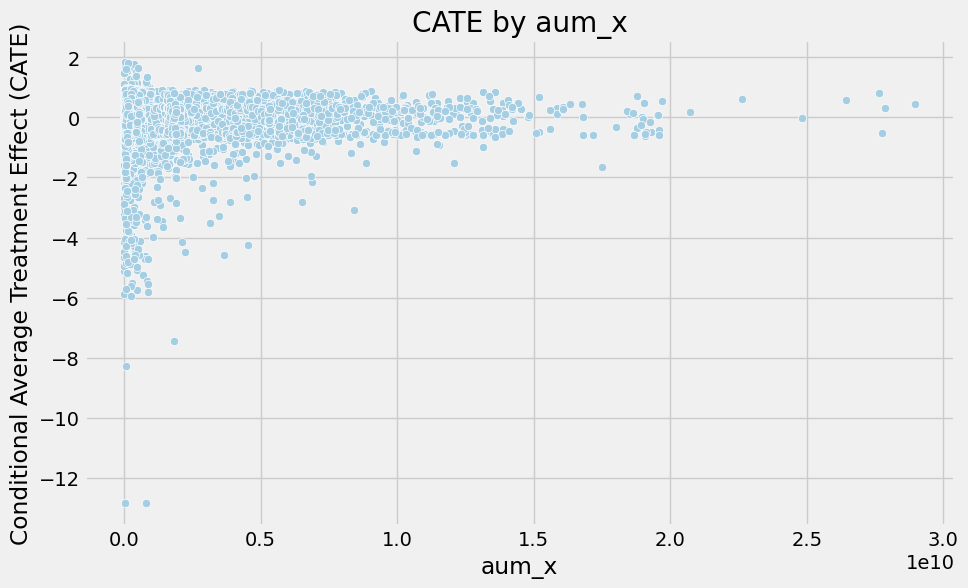

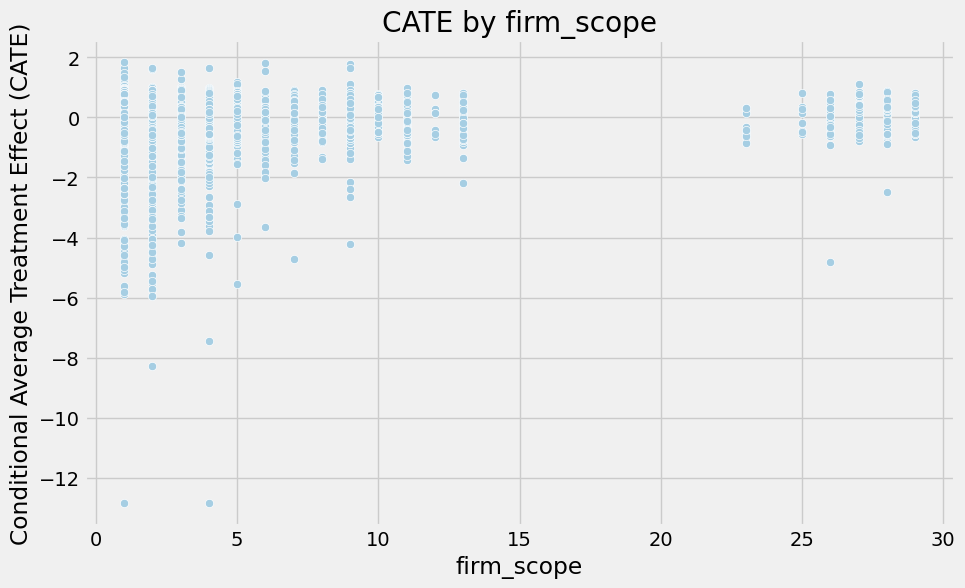

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'te_pred' is your CATE predictions from the model and data is your dataframe
for covariate in ['aum_firm', 'aum_x', 'firm_scope']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[covariate], y=data['CATE'])
    plt.title(f'CATE by {covariate}')
    plt.xlabel(covariate)
    plt.ylabel('Conditional Average Treatment Effect (CATE)')
    plt.show()

In [49]:
# Define small and large firms based on a threshold (e.g., median AUM)
threshold = data['aum_firm'].median()
data['firm_size'] = data['aum_firm'].apply(lambda x: 'Small' if x < threshold else 'Large')

# Group by firm size and calculate mean CATE
grouped = data.groupby('firm_size')['CATE'].agg(['mean', 'std', 'count']).reset_index()
print(grouped)

  firm_size      mean       std  count
0     Large -0.040883  0.540852  16017
1     Small -0.040149  0.550614  12277


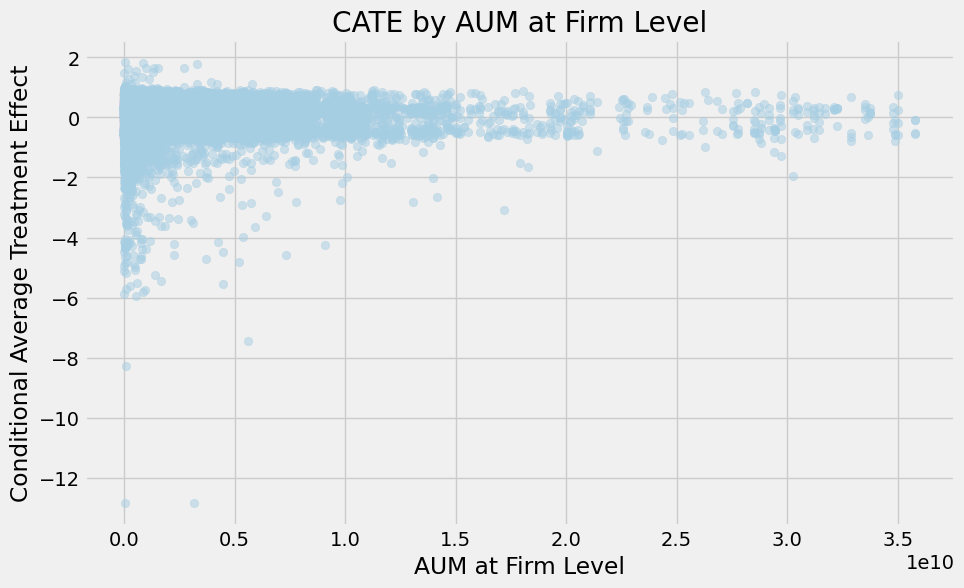

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(data['aum_firm'], data['CATE'], alpha=0.5)
plt.title('CATE by AUM at Firm Level')
plt.xlabel('AUM at Firm Level')
plt.ylabel('Conditional Average Treatment Effect')
plt.show()

In [51]:
# Example: Mean CATE for treated vs. untreated
means = data.groupby('TREATED')['CATE'].mean()
print("Mean CATE for Treated vs. Untreated Groups:", means)

Mean CATE for Treated vs. Untreated Groups: TREATED
0   -0.040507
1   -0.043234
Name: CATE, dtype: float64


In [36]:
# Calculate descriptive statistics for covariates by treatment status
desc_stats = data.groupby('TREATED').agg({'aum_firm': ['mean', 'std', 'min', 'max'],
                                          'aum_x': ['mean', 'std', 'min', 'max'],
                                          'firm_scope': ['mean', 'std', 'min', 'max'],
                                          'firm_age': ['mean', 'std', 'min', 'max'],
                                          'age': ['mean', 'std', 'min', 'max']})
print(desc_stats)

             aum_firm                                                 aum_x  \
                 mean           std         min           max          mean   
TREATED                                                                       
0        1.664421e+09  4.065126e+09   1000000.0  1.011344e+11  6.669981e+08   
1        4.466784e+09  4.269314e+09  40450103.0  1.637647e+10  7.669859e+08   

                                               firm_scope                 \
                  std        min           max       mean       std  min   
TREATED                                                                    
0        1.582037e+09  1000000.0  5.972600e+10   2.256451  2.320968  1.0   
1        1.153633e+09  5324068.0  4.841352e+09  11.980216  8.919561  1.0   

                 firm_age                            age                      
          max        mean        std min  max       mean        std min  max  
TREATED                                                          

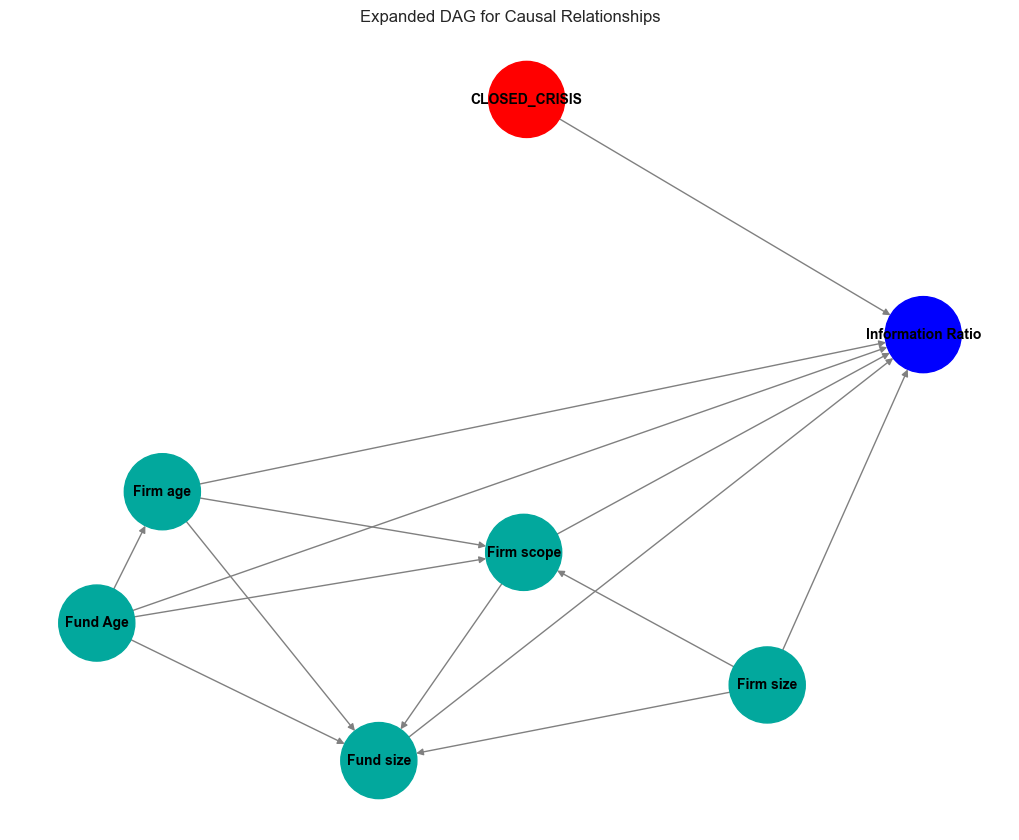

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the nodes (variables)
nodes = {
    'CLOSED_CRISIS': 'treatment',
    'Information Ratio': 'outcome',
    'Fund size': 'confounder',
    'Fund Age': 'confounder',
    'Firm scope': 'confounder',
    'Firm age': 'confounder',
    'Firm size': 'confounder'
}

# Define node colors
node_colors = {
    'treatment': 'red',
    'outcome': 'blue',
    'confounder': '#02a89d'  # Darker green
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph with types
for node, node_type in nodes.items():
    G.add_node(node, type=node_type)

# Add directed edges based on assumed causal relationships
G.add_edge('CLOSED_CRISIS', 'Information Ratio')

# Size, age, scope, and firm age affect 'Information Ratio'
G.add_edge('Fund size', 'Information Ratio')
G.add_edge('Fund Age', 'Information Ratio')
G.add_edge('Firm scope', 'Information Ratio')
G.add_edge('Firm age', 'Information Ratio')
G.add_edge('Firm size', 'Information Ratio')

# Interdependencies between control variables
G.add_edge('Fund Age', 'Fund size')
G.add_edge('Fund Age', 'Firm scope')
G.add_edge('Fund Age', 'Firm age')
G.add_edge('Firm age', 'Fund size')
G.add_edge('Firm age', 'Firm scope')
G.add_edge('Firm scope', 'Fund size')
G.add_edge('Firm size', 'Fund size') # Firms managing larger sizes could have larger funds
G.add_edge('Firm size', 'Firm scope') # Firms with larger size could have more funds

# Get node color map
colors = [node_colors[G.nodes[node]['type']] for node in G.nodes()]

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color=colors, font_size=10, font_weight='bold', edge_color='gray')
plt.title('Expanded DAG for Causal Relationships')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
dag = nx.DiGraph()

# Add nodes representing variables
nodes = ["TREATED", "IR", "AUM_firm", "AUM_x", "Firm_Scope", "Firm_Age", "Fund_Age"]
dag.add_nodes_from(nodes)

# Define edges based on your causal assumptions
edges = [("TREATED", "IR"), ("AUM_firm", "IR"), ("AUM_x", "IR"),
         ("Firm_Scope", "IR"), ("Firm_Age", "IR"), ("Fund_Age", "IR"),
         ("TREATED", "AUM_firm"), ("TREATED", "Firm_Scope")]

dag.add_edges_from(edges)

# Draw the DAG
pos = nx.layout.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, arrows=True)
plt.title('Directed Acyclic Graph (DAG) of the Study')
plt.show()

In [19]:
import pandas as pd
from causalml.inference.meta import LRSRegressor

# Prepare data
X = regression_df[['log_aum', 'log_age', 'log_firmscope', 'log_firm_age']]
treatment = regression_df['TREATED']
outcome = regression_df['ir']

# Ensure there are no non-numeric values
X = X.apply(pd.to_numeric, errors='coerce')
treatment = treatment.apply(pd.to_numeric, errors='coerce')
outcome = outcome.apply(pd.to_numeric, errors='coerce')

# Check for and handle any remaining missing values
X = X.fillna(X.mean())
treatment = treatment.fillna(treatment.mean())
outcome = outcome.fillna(outcome.mean())

# Use a meta-learner for causal inference
learner = LRSRegressor()
learner.fit(X=X, treatment=treatment, y=outcome)

# Estimate treatment effects
te = learner.estimate_ate(X=X, treatment=treatment, y=outcome)
print("Average Treatment Effect (ATE) Estimate:")
print(f"Point Estimate: {te[0][0]}")
print(f"95% Confidence Interval: ({te[1][0]}, {te[2][0]})")

if te[1][0] <= 0 <= te[2][0]:
    print("The ATE is not statistically significant at the 95% confidence level.")
else:
    print("The ATE is statistically significant at the 95% confidence level.")


Average Treatment Effect (ATE) Estimate:
Point Estimate: -0.47890234013406807
95% Confidence Interval: (-0.5329716491378723, -0.4248330311302638)
The ATE is statistically significant at the 95% confidence level.


/var/folders/jy/cfb14z9n637_y0c4jp4g2j1h0000gn/T/ipykernel_78390/606898426.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


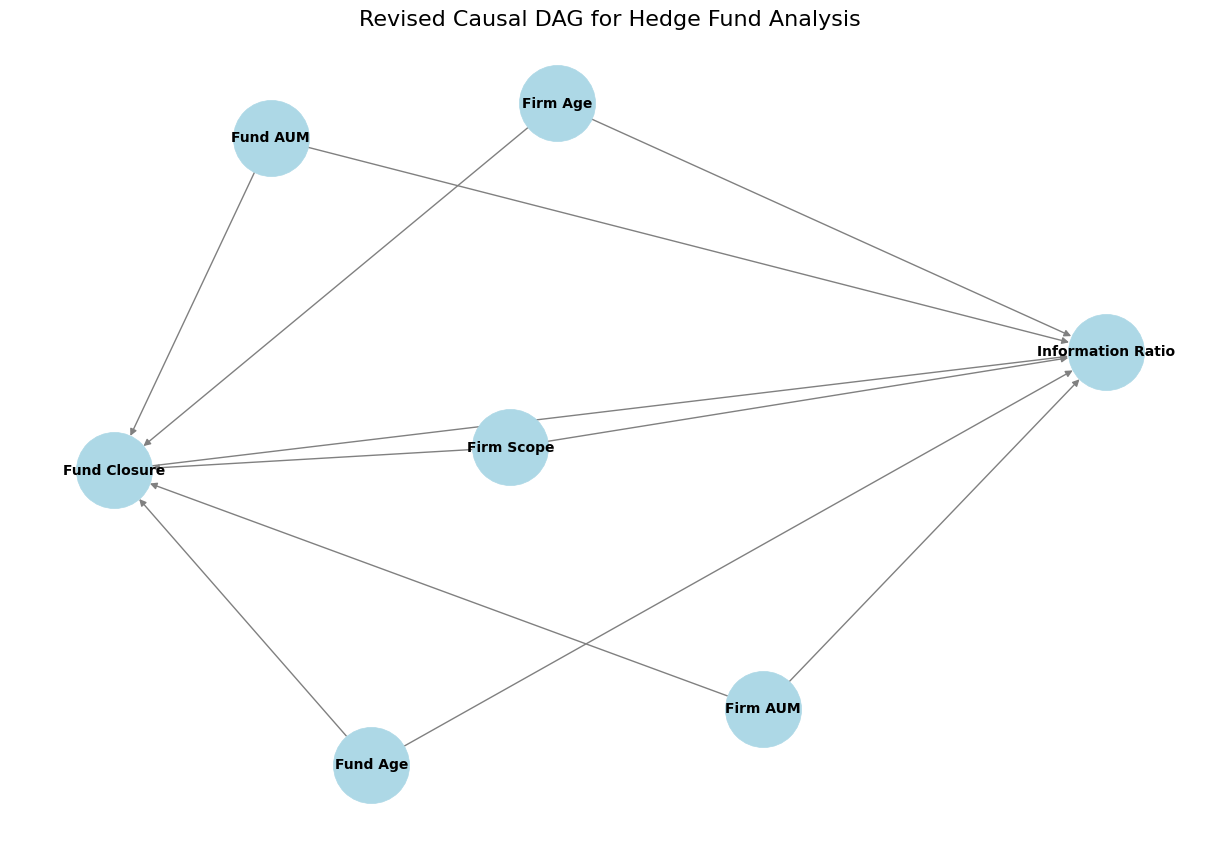

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ['Fund Closure', 'Firm AUM', 'Fund AUM', 'Firm Scope', 
         'Firm Age', 'Fund Age', 'Information Ratio']
G.add_nodes_from(nodes)

# Add edges (representing causal relationships)
edges = [
    ('Firm AUM', 'Fund Closure'),
    ('Fund AUM', 'Fund Closure'),
    ('Firm Scope', 'Fund Closure'),
    ('Firm Age', 'Fund Closure'),
    ('Fund Age', 'Fund Closure'),
    ('Fund Closure', 'Information Ratio'),
    ('Firm AUM', 'Information Ratio'),
    ('Fund AUM', 'Information Ratio'),
    ('Firm Scope', 'Information Ratio'),
    ('Firm Age', 'Information Ratio'),
    ('Fund Age', 'Information Ratio')
]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_weight='bold', 
        arrows=True, edge_color='gray')

# Add edge labels
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Revised Causal DAG for Hedge Fund Analysis", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()